# A/B Testing ML Models in Production

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) is a fully managed service that provides developers and data scientists the ability to quickly build, train, and deploy machine learning (ML) models. Tens of thousands of customers, including Intuit, Voodoo, ADP, Cerner, Dow Jones, and Thomson Reuters, use Amazon SageMaker to remove the heavy lifting from the ML process. With Amazon SageMaker, you can deploy your ML models on hosted endpoints and get inference results in real time. You can easily view the performance metrics for your endpoints in [Amazon CloudWatch](http://aws.amazon.com/cloudwatch), enable [autoscaling](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html) to automatically scale endpoints based on traffic, and update your models in production without losing any availability.

In many cases, such as e-commerce applications, offline model evaluation isn’t sufficient, and you need to A/B test models in production before making the decision of updating models. With Amazon SageMaker, you can easily perform A/B testing on ML models by running multiple production variants on an endpoint. You can use production variants to test ML models that have been trained using different training datasets, algorithms, and ML frameworks; test how they perform on different instance types; or a combination of all of the above.

## Introduction to A/B testing with Amazon SageMaker

In production ML workflows, data scientists and engineers frequently try to improve their models in various ways, such as by performing [automated hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), training on additional or more recent data, or improving feature selection. Performing A/B testing on the new model and the old model with production traffic can be an effective final step in the validation process for a new model. In A/B testing, you test different variants of your models and compare how each variant performs relative to each other. If the new version delivers performance that is better or equal to the previously existing version, you replace the older model.

Amazon SageMaker enables you to test multiple models or model versions behind the same endpoint using production variants. Each `ProductionVariant` identifies an ML model and the resources deployed for hosting the model. You can distribute endpoint invocation requests across multiple production variants by providing the traffic distribution for each variant or invoking a variant directly for each request. In the following sections, we look at both methods for testing ML models.

### Testing models by distributing traffic to variants

To test multiple models by distributing traffic between them, specify the percentage of the traffic to route to each model by specifying the weight for each production variant in the [endpoint configuration](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html). Amazon SageMaker distributes the traffic between production variants based on the respective weights that you provided. This is the default behavior when using production variants. The following diagram shows how this works in more detail. Each inference response also contains the name of the variant that processed the request.

![](./images/production-variants.gif)

## Notebook overview

You will use a Jupyter notebook in Amazon SageMaker to create an endpoint that hosts two models (using `ProductionVariant`). Both models were trained using the Amazon SageMaker [built-in XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) on a dataset for predicting mobile operator customer churn. For more information about how the models were trained, see [Customer Churn Prediction with XGBoost](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb). In the following use case, we trained each model on different subsets of the same dataset and used different versions of the XGBoost algorithm for each model.

Try these activities yourself by using the [sample A/B Testing with Amazon SageMaker’ Jupyter Notebook](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker_endpoints/a_b_testing). You can run it either in [Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-studio.html) or in an Amazon SageMaker notebook instance. The dataset we use is publicly available and mentioned in the book Discovering Knowledge in Data by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

The walkthrough includes the following steps:

* [Creating and deploying the models](#Step-1:-Create-and-deploy-the-models)
* [Invoking the deployed models](#Step-2:-Invoke-the-deployed-models)
* [Evaluating variant performance](#Step-3:-Evaluate-variant-performance)
* [Dialing up inference traffic to your chosen variant in production](#Step-4:-Dialing-up-our-chosen-variant-in-production)

### Configuration

Let’s set up some required imports and basic initial variables:

In [1]:
%%time
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-VariantTargeting"

CPU times: user 1.45 s, sys: 299 ms, total: 1.75 s
Wall time: 1.87 s


Additionally, you will need to add the `GetMetricStatistics` action to your `AmazonSageMakerServiceCatalogProductsUseRole`, found under `Roles` in the Access Management submenu in the navigation menu of the IAM user interface, as shown below (click the Edit button and add the action manually, then save):

![](images/iam-role-screenshot.png)

### Step 1: Create and deploy the models

#### First, we upload our pre-trained models to Amazon S3

This code uploads two pre-trained XGBoost models that are ready for you to deploy. These models were trained using the XGB Churn Prediction Notebook in SageMaker. You can also use your own pre-trained models in this step. If you already have a pretrained model in Amazon S3, you can add it by specifying the s3_key.

The models in this example are used to predict the probability of a mobile customer leaving their current mobile operator.

In [3]:
model_url = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model2.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://sagemaker-us-east-1-977296963831/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model.tar.gz',
 's3://sagemaker-us-east-1-977296963831/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model2.tar.gz')

#### Creating model definitions

Start with deploying the pre-trained churn prediction models. Here, you create the model objects with the image and model data:

In [4]:
from sagemaker.image_uris import retrieve


model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = retrieve("xgboost", boto3.Session().region_name, "0.90-1")
image_uri2 = retrieve("xgboost", boto3.Session().region_name, "0.90-2")

sm_session.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

sm_session.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

'DEMO-xgb-churn-pred2-2023-01-13-21-11-41'

#### Creating variants

We now create two variants, each with its own different model (these could also have different instance types and counts).

We set an initial_weight of “1” for both variants: this means 50% of our requests go to `Variant1`, and the remaining 50% of all requests to `Variant2` (the sum of weights across both variants is 2 and each variant has weight assignment of 1. This implies each variant receives 1/2, or 50%, of the total traffic).

In [5]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant1",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=model_name2,
    instance_type="ml.m5.xlarge",
    initial_instance_count=1,
    variant_name="Variant2",
    initial_weight=1,
)

(variant1, variant2)

({'ModelName': 'DEMO-xgb-churn-pred-2023-01-13-21-11-41',
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1,
  'InitialInstanceCount': 1,
  'InstanceType': 'ml.m5.xlarge'},
 {'ModelName': 'DEMO-xgb-churn-pred2-2023-01-13-21-11-41',
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1,
  'InitialInstanceCount': 1,
  'InstanceType': 'ml.m5.xlarge'})

#### Deployment

Let’s go ahead and deploy our two variants to a SageMaker endpoint:

In [6]:
endpoint_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sm_session.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

EndpointName=DEMO-xgb-churn-pred-2023-01-13-21-11-59
-----!

'DEMO-xgb-churn-pred-2023-01-13-21-11-59'

### Step 2: Invoke the deployed models

You can now send data to this endpoint to get inferences in real time.

This step invokes the endpoint with included sample data for about 2 minutes.

In [7]:
# get a subset of test data for a quick test
!tail -120 test_data/test-dataset-input-cols.csv > test_data/test_sample_tail_input_cols.csv
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
        time.sleep(0.5)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2023-01-13-21-11-59. 
Please wait...
........................................................................................................................Done!


#### Invocations per variant

Amazon SageMaker emits metrics such as Latency and Invocations (full list of metrics [here](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) for each variant in Amazon CloudWatch. Let’s query CloudWatch to get number of Invocations per variant, to show how invocations are split across variants:

In [8]:
import pandas as pd

cw = boto3.Session().client("cloudwatch")


def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant1["VariantName"], start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant2["VariantName"], start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


,Variant1,Variant2
Timestamp,,
2023-01-13 21:14:00+00:00,34.0,19.0
2023-01-13 21:15:00+00:00,33.0,34.0
2023-01-13 21:17:00+00:00,0.0,0.0
2023-01-13 21:18:00+00:00,0.0,0.0
2023-01-13 21:19:00+00:00,0.0,0.0
2023-01-13 21:20:00+00:00,0.0,0.0
2023-01-13 21:21:00+00:00,0.0,0.0
2023-01-13 21:22:00+00:00,0.0,0.0
2023-01-13 21:23:00+00:00,0.0,0.0


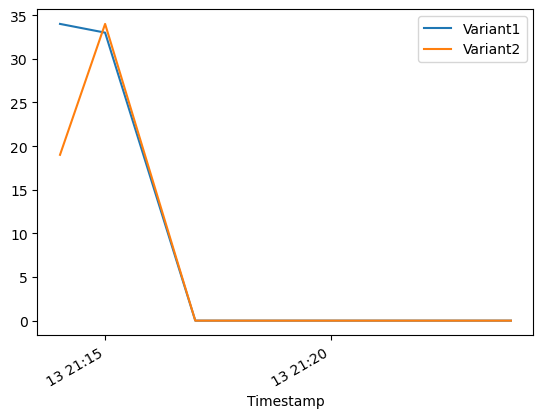

In [10]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

#### Invoke a specific variant

Now, let’s use the new feature that was released today to invoke a specific variant. For this, we simply use the new parameter to define which specific ProductionVariant we want to invoke. Let us use this to invoke `Variant1` for all requests:

In [11]:
import numpy as np

predictions = ""

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant1["VariantName"],
        )
        predictions = ",".join([predictions, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=",")

# Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2023-01-13-21-11-59. 
Please wait...
........................................................................................................................Done!


When we again check the traffic per variant, this time we see that the number of invocations only incremented for `Variant1`, because all invocations were targeted at that variant:

,Variant1,Variant2
Timestamp,,
2023-01-13 21:14:00+00:00,34.0,19.0
2023-01-13 21:15:00+00:00,33.0,34.0
2023-01-13 21:17:00+00:00,0.0,0.0
2023-01-13 21:18:00+00:00,0.0,0.0
2023-01-13 21:19:00+00:00,0.0,0.0
2023-01-13 21:20:00+00:00,0.0,0.0
2023-01-13 21:21:00+00:00,0.0,0.0
2023-01-13 21:22:00+00:00,0.0,0.0
2023-01-13 21:23:00+00:00,0.0,0.0


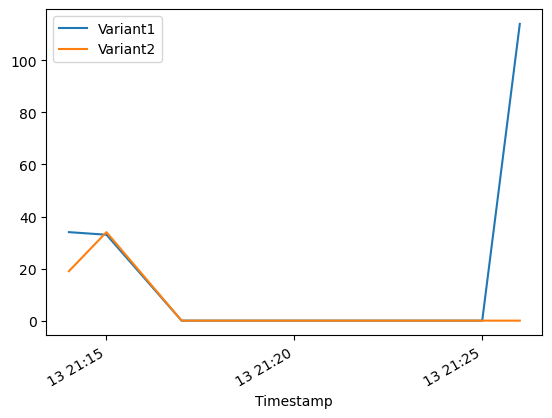

In [12]:
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

### Step 3: Evaluate variant performance

#### Evaluating Variant 1

Using the new targeting feature, let us evaluate the accuracy, precision, recall, F1 score, and ROC/AUC for `Variant1`:

Accuracy: 0.9583333333333334
Precision: 0.9411764705882353
Recall: 0.8
F1 Score: 0.8648648648648648
AUC is 0.895


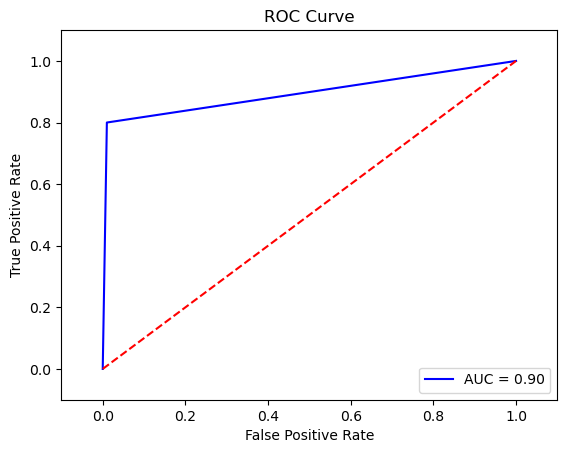

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Let's get the labels of our test set; we will use these to evaluate our predictions
!tail -121 test_data/test-dataset.csv > test_data/test_dataset_sample_tail.csv
df_with_labels = pd.read_csv("test_data/test_dataset_sample_tail.csv")
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()

# Calculate accuracy
accuracy = sum(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = sum(preds[preds == 1] == labels[preds == 1]) / len(preds[preds == 1])
print(f"Precision: {precision}")

# Calculate recall
recall = sum(preds[preds == 1] == labels[preds == 1]) / len(labels[labels == 1])
print(f"Recall: {recall}")

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Calculate AUC
auc = round(roc_auc_score(labels, preds), 4)
print("AUC is " + repr(auc))

fpr, tpr, _ = metrics.roc_curve(labels, preds)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

Next, we collect data for `Variant2`:

In [14]:
predictions2 = ""
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant2["VariantName"],
        )
        predictions2 = ",".join([predictions2, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert to numpy array
pred_np2 = np.fromstring(predictions2[1:], sep=",")

# Convert to binary predictions
thresh = 0.5
preds2 = np.where(pred_np2 > threshold, 1, 0)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2023-01-13-21-11-59. 
Please wait...
........................................................................................................................Done!


When we again check the traffic per variant, this time we see that the number of invocations only incremented for `Variant2`, because all invocations were targeted at that variant:

,Variant1,Variant2
Timestamp,,
2023-01-13 21:14:00+00:00,34.0,19.0
2023-01-13 21:15:00+00:00,33.0,34.0
2023-01-13 21:17:00+00:00,0.0,0.0
2023-01-13 21:18:00+00:00,0.0,0.0
2023-01-13 21:19:00+00:00,0.0,0.0
2023-01-13 21:20:00+00:00,0.0,0.0
2023-01-13 21:21:00+00:00,0.0,0.0
2023-01-13 21:22:00+00:00,0.0,0.0
2023-01-13 21:23:00+00:00,0.0,0.0


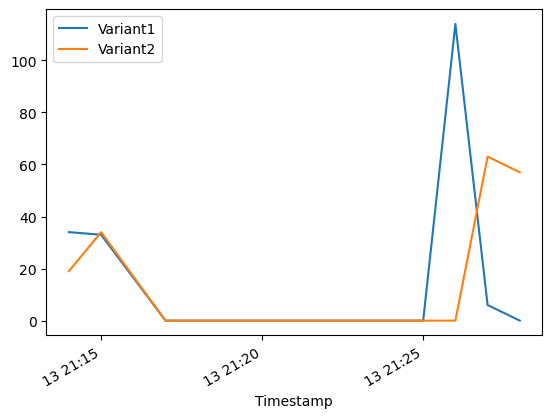

In [15]:
time.sleep(60)  # give metrics time to catch up
plot_endpoint_metrics()

Evaluating `Variant2`:

Accuracy: 0.9583333333333334
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
AUC is 0.915


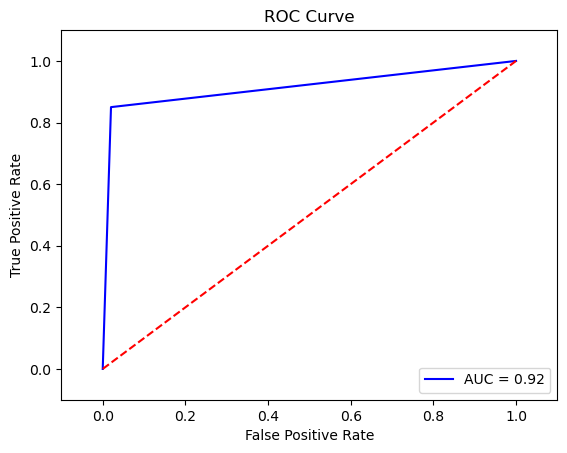

In [16]:
# Calculate accuracy
accuracy2 = sum(preds2 == labels) / len(labels)
print(f"Accuracy: {accuracy2}")

# Calculate precision
precision2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(preds2[preds2 == 1])
print(f"Precision: {precision2}")

# Calculate recall
recall2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(labels[labels == 1])
print(f"Recall: {recall2}")

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print(f"F1 Score: {f1_score2}")

auc2 = round(roc_auc_score(labels, preds2), 4)
print("AUC is " + repr(auc2))

fpr2, tpr2, _ = metrics.roc_curve(labels, preds2)

plt.title("ROC Curve")
plt.plot(fpr2, tpr2, "b", label="AUC = %0.2f" % auc2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

We see that `Variant2` is performing better for most of our defined metrics, so this is the one we’re likely to choose to dial up in production.

### Step 4: Dialing up our chosen variant in production

Now that we have determined `Variant2` to be better as compared to `Variant1`, we will shift more traffic to it.

We can continue to use `TargetVariant` to continue invoking a chosen variant. A simpler approach is to update the weights assigned to each variant using `UpdateEndpointWeightsAndCapacities`. This changes the traffic distribution to your production variants without requiring updates to your endpoint.

Recall our variant weights are as follows:

In [17]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

We’ll first write a method to easily invoke our endpoint (a copy of what we had been previously doing):

In [18]:
def invoke_endpoint_for_two_minutes():
    with open("test_data/test-dataset-input-cols.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)

We invoke our endpoint for a bit, to show the even split in invocations:

In [ ]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

.........................................................................................................................................................................

Now let us shift 75% of the traffic to Variant2 by assigning new weights to each variant using `UpdateEndpointWeightsAndCapacities`. Amazon SageMaker will now send 75% of the inference requests to `Variant2` and remaining 25% of requests to `Variant1`:

In [20]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 25, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 75, "VariantName": variant2["VariantName"]},
    ],
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:977296963831:endpoint/demo-xgb-churn-pred-2023-01-13-21-11-59',
 'ResponseMetadata': {'RequestId': '3c723422-6f11-47ff-a840-4de168fa965a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3c723422-6f11-47ff-a840-4de168fa965a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Fri, 13 Jan 2023 21:35:27 GMT'},
  'RetryAttempts': 0}}

In [21]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
.......................................................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

Now let’s check how that has impacted invocation metrics:

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2023-01-13 21:29:00+00:00,16.0,14.0
2023-01-13 21:30:00+00:00,30.0,29.0
2023-01-13 21:31:00+00:00,27.0,33.0
2023-01-13 21:32:00+00:00,33.0,26.0
2023-01-13 21:33:00+00:00,30.0,29.0
2023-01-13 21:34:00+00:00,28.0,32.0
2023-01-13 21:35:00+00:00,3.0,4.0
2023-01-13 21:36:00+00:00,4.0,10.0
2023-01-13 21:37:00+00:00,12.0,47.0


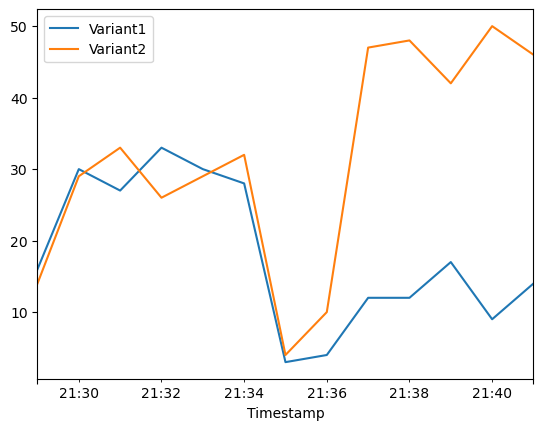

In [22]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

We can continue to monitor our metrics and when we’re satisfied with a variant’s performance, we can route 100% of the traffic over the variant. We used `UpdateEndpointWeightsAndCapacities` to update the traffic assignments for the variants. The weight for `Variant1` is set to 0 and the weight for `Variant2` is set to 1. Therefore, Amazon SageMaker will send 100% of all inference requests to `Variant2`.

In [23]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 0, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 1, "VariantName": variant2["VariantName"]},
    ],
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
.......................................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2023-01-13 21:29:00+00:00,16.0,14.0
2023-01-13 21:30:00+00:00,30.0,29.0
2023-01-13 21:31:00+00:00,27.0,33.0
2023-01-13 21:32:00+00:00,33.0,26.0
2023-01-13 21:33:00+00:00,30.0,29.0
2023-01-13 21:34:00+00:00,28.0,32.0
2023-01-13 21:35:00+00:00,3.0,4.0
2023-01-13 21:36:00+00:00,4.0,10.0
2023-01-13 21:37:00+00:00,12.0,47.0


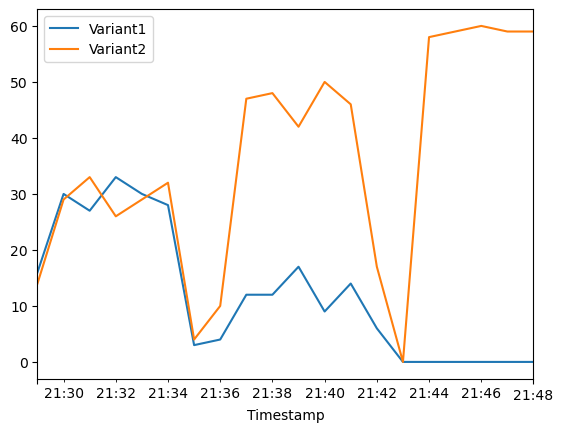

In [24]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

The Amazon CloudWatch metrics for the total invocations for each variant below shows us that all inference requests are being processed by `Variant2` and there are no inference requests processed by `Variant1`.

You can now safely update your endpoint and delete `Variant1` from your endpoint. You can also continue testing new models in production by adding new variants to your endpoint and following steps 2 - 4.

#### Delete the endpoint

If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges:

In [52]:
sm_session.delete_endpoint(endpoint_name)